In [25]:
import requests, time
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
api = KaggleApi()
api.authenticate()

In [15]:
# CORRECT IMPORT
import zipfile

# Initialize and authenticate
api = KaggleApi()
api.authenticate()

# Download dataset - use the correct identifier from Kaggle URL
# Format: "username/dataset-name"
dataset = "jesusandrade1/alcohol-sales-from-usa-company"
api.dataset_download_files(dataset, path="./", unzip=True)

# Now you can read the CSV files


Dataset URL: https://www.kaggle.com/datasets/jesusandrade1/alcohol-sales-from-usa-company


In [35]:
df = pd.read_csv("CSV\Alcohol sales.csv")  # Replace with actual filename
print(df.head())

       date       brand      sales
0  04/10/21  Producto 1     $87.94
1  04/10/21  Producto 2    $260.15
2  04/10/21  Producto 3    $176.41
3  04/10/21  Producto 4    $239.88
4  04/10/21  Producto 5  $2,098.09


In [43]:
df.dtypes

date     datetime64[ns]
brand            object
sales           float64
dtype: object

In [38]:
df['sales'] = df['sales'].str.replace('$', '', regex=False)
df['sales'] = df['sales'].str.replace(',', '', regex=False)
df['sales'] = df['sales'].astype(float)

In [42]:
df['date'] = pd.to_datetime(df['date'])


C:\Users\Laptop\AppData\Local\Temp\ipykernel_28244\584440916.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


=== MISSINGNESS PER COLUMN ===
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

=== ROWS WITH ALL DATA MISSING ===
Count: 0


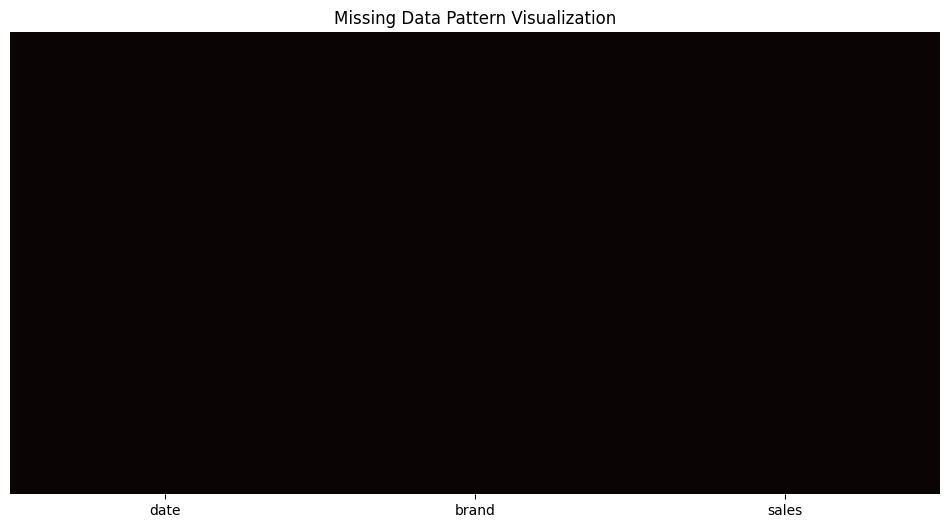

In [5]:
# Calculate missingness per column
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage',ascending=False)

print("=== MISSINGNESS PER COLUMN ===")
print(missing_summary[missing_summary['Missing_Count'] > 0])

# 2. Check for rows that are completely empty (unlikely but good to check)
print(f"\n=== ROWS WITH ALL DATA MISSING ===")
print(f"Count: {df.isnull().all(axis=1).sum()}")

# 3. Create a missing data heatmap to see patterns
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="mako", yticklabels=False)
plt.title('Missing Data Pattern Visualization')
plt.show()

In [44]:
import numpy as np

In [45]:
campaign_start = pd.Timestamp('2023-01-10')

df['Campaign'] = np.where(
    df['date'] < campaign_start,
    'Before',
    'After'
)

# Count the results
campaign_counts = df['Campaign'].value_counts()
print(f"\nCampaign distribution:\n{campaign_counts}")


Campaign distribution:
Campaign
Before    7514
After     3430
Name: count, dtype: int64


In [68]:
Cat_cols = ['brand', 'Campaign']
Num_cols = ['sales', 'date']
chosen_cat = 'Campaign'

In [70]:
top_7_brands = df.groupby('brand')['sales'].sum().nlargest(7).index

# Filter dataframe to only these brands
df_top_7 = df[df['brand'].isin(top_7_brands)]

df_top_7.head()

,date,brand,sales,Campaign
4,2021-04-10,Producto 5,2098.09,Before
5,2021-04-10,Producto 6,2341.76,Before
6,2021-04-10,Producto 7,792.51,Before
8,2021-04-10,Producto 9,2771.14,Before
13,2021-04-10,Producto 14,1704.43,Before


# CAT vs CAT

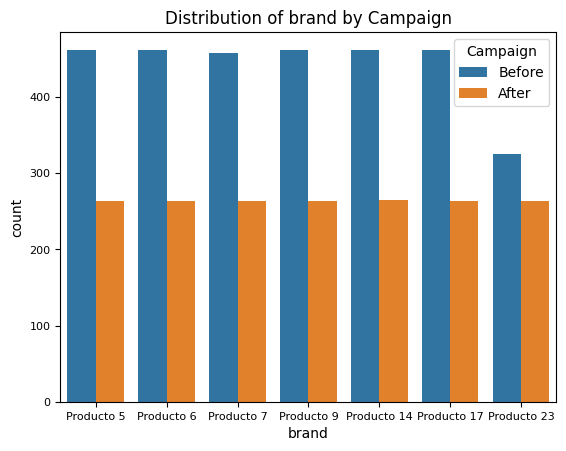

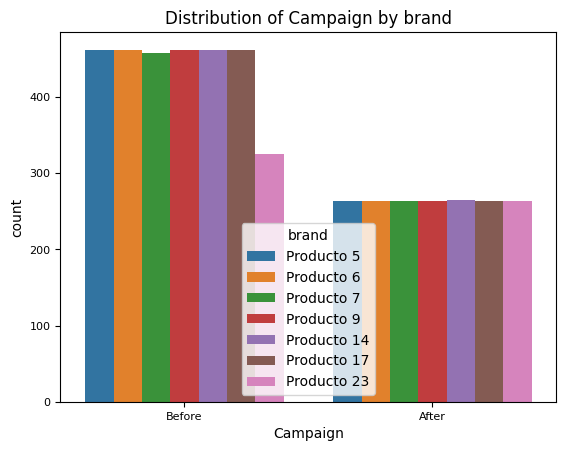

In [77]:
for rows in Cat_cols:
    for col in Cat_cols:
        if rows == col:
            continue
        # Use rows (the specific categorical variable) for x-axis
        sns.countplot(data=df_top_7, x=rows, hue=col)
        plt.tick_params(axis='both', which='major', labelsize=8)
        plt.title(f'Distribution of {rows} by {col}')
        
        plt.show()

## Cat VS num

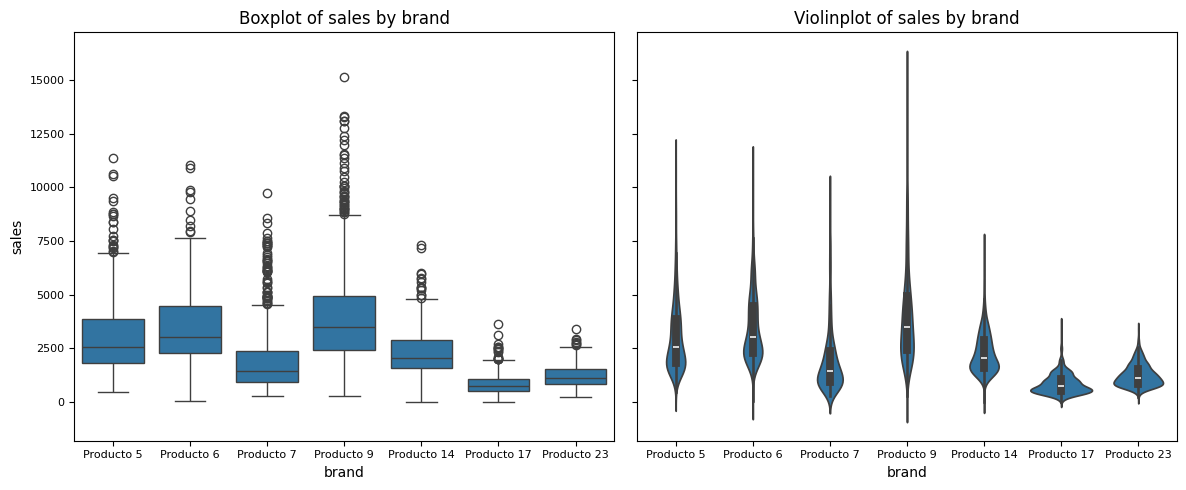

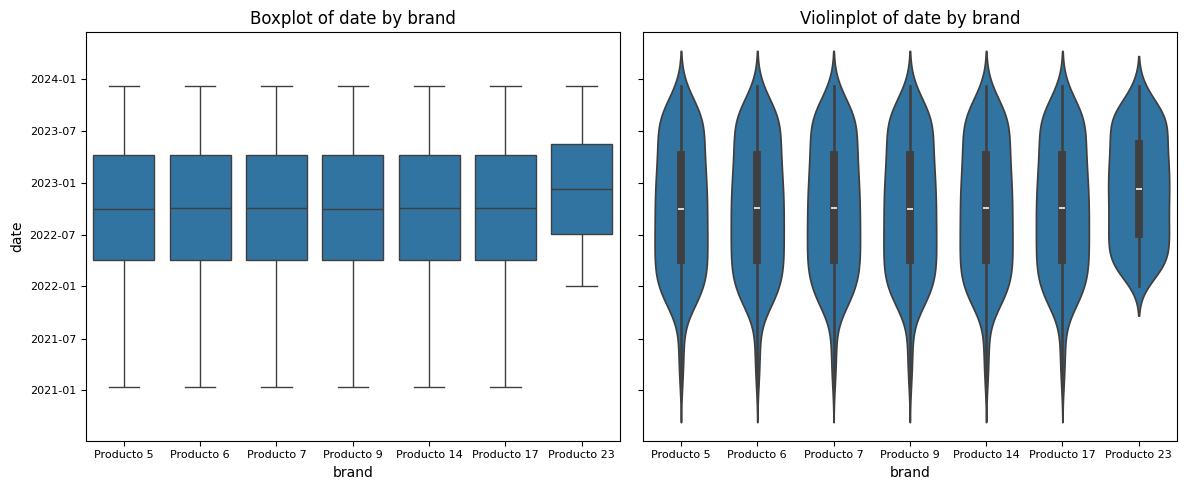

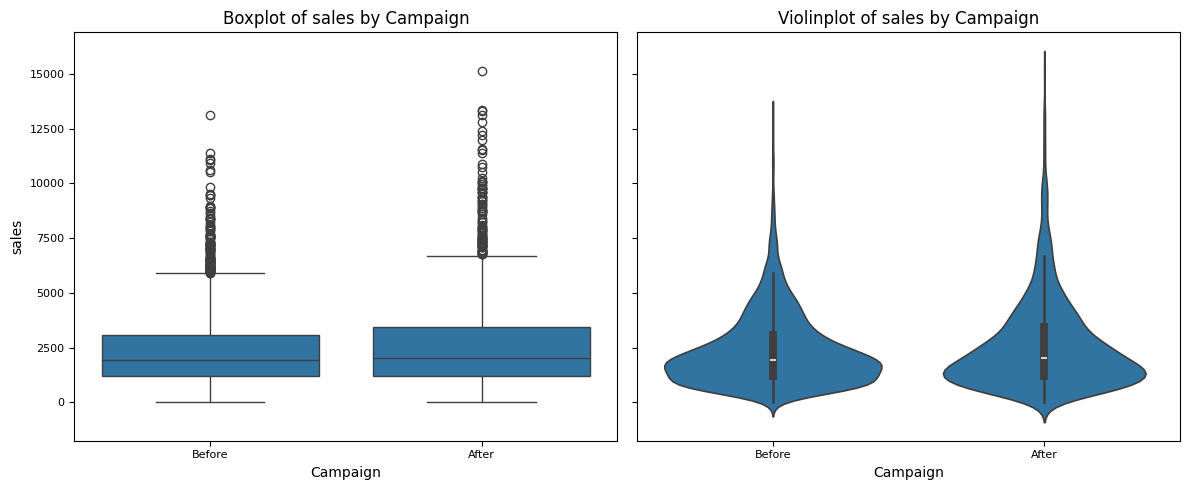

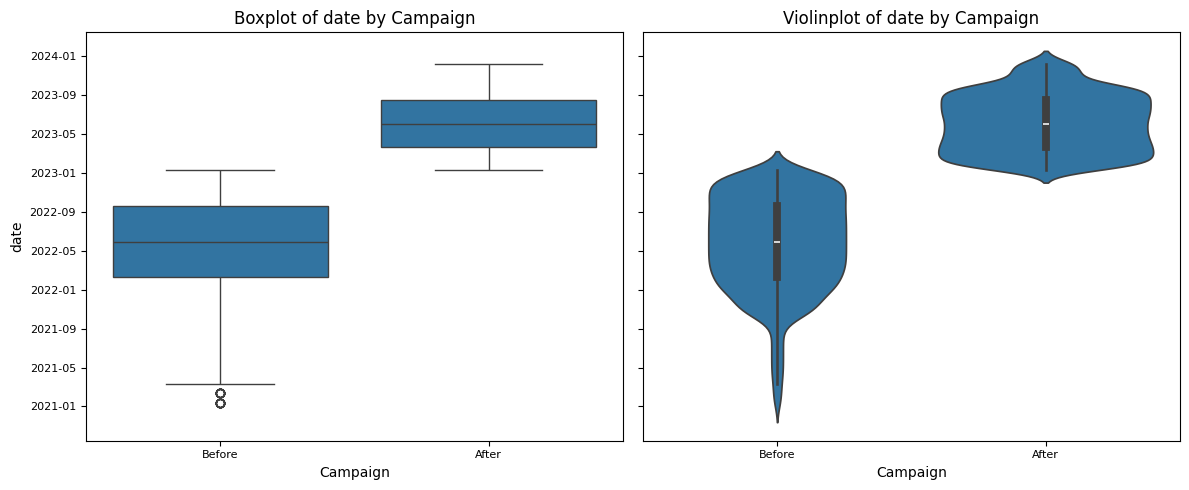

In [86]:
for cat in Cat_cols:
    for num in Num_cols:
        # Create subplots for boxplot and violinplot  
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        # Boxplot
        sns.boxplot(data=df_top_7, x=cat, y=num, ax=axes[0])
        axes[0].set_title(f"Boxplot of {num} by {cat}")
        axes[0].tick_params(axis='both', which='major', labelsize=8)
        
        # Violinplot
        sns.violinplot(data=df_top_7, x=cat, y=num, ax=axes[1])
        axes[1].set_title(f"Violinplot of {num} by {cat}")
        axes[1].tick_params(axis='both', which='major', labelsize=8)

        plt.tight_layout()
        plt.show()

# Num VS Num

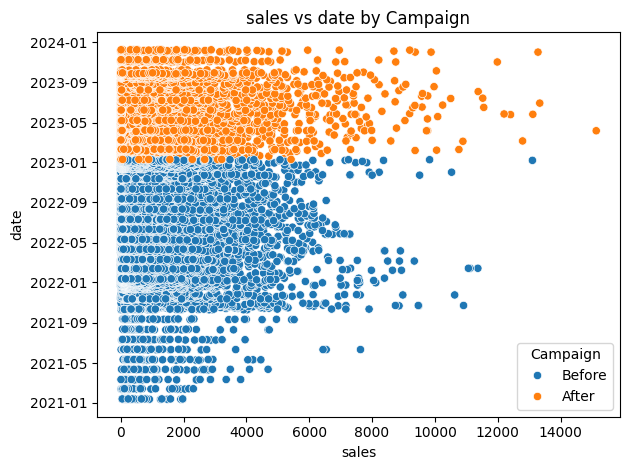

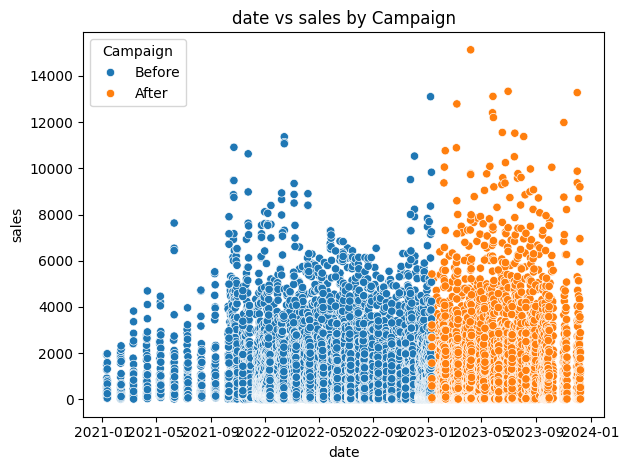

In [93]:
for rows in Num_cols:
    for col in Num_cols:
        if rows == col:
            continue
        sns.scatterplot(
            data=df,
            x=rows,
            y=col,
            hue=chosen_cat  
            )
        plt.title(f'{rows} vs {col} by {chosen_cat}')
        plt.tight_layout()
        plt.show()

# EDA

In [96]:
from scipy import stats
import warnings
from scipy.stats import skew, kurtosis
warnings.filterwarnings('ignore')
from datetime import datetime

## Univariante

In [ ]:
print("=== DATASET INFORMATION ===")
print(f"Shape: {df.shape}")
print(f"Total records: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique brands: {df['brand'].nunique()}")

print("\n=== SALES STATISTICS ===")
print(df['sales'].describe())

print("\n=== DISTRIBUTION METRICS ===")
print(f"Skewness: {skew(df['sales'].dropna()):.4f}")
print(f"Kurtosis: {kurtosis(df['sales'].dropna()):.4f}")

# Calculate quartiles
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1
print(f"Interquartile Range (IQR): ${IQR:.2f}")

# Outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['sales'] < lower_bound) | (df['sales'] > upper_bound)]
print(f"Potential outliers (using IQR method): {len(outliers)} records")

print("\n=== DATE STATISTICS ===")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
print(f"Unique dates: {df['date'].nunique()}")
print(f"Most frequent date: {df['date'].mode().iloc[0].strftime('%Y-%m-%d')}")

# Date-based metrics
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()

print("\n=== YEARLY STATISTICS ===")
yearly_stats = df.groupby('year')['sales'].agg(['count', 'sum', 'mean', 'median'])
print(yearly_stats)

print("\n=== MONTHLY PATTERNS ===")
monthly_avg = df.groupby('month')['sales'].mean().sort_values(ascending=False)
print(monthly_avg)

print("\n=== DAY OF WEEK PATTERNS ===")
dow_avg = df.groupby('day_of_week')['sales'].mean()
print(dow_avg)

=== DATASET INFORMATION ===
Shape: (10944, 5)
Total records: 10944
Date range: 2021-01-11 00:00:00 to 2023-12-09 00:00:00
Unique brands: 25

=== SALES STATISTICS ===
count    10944.000000
mean      1310.038316
std       1646.480628
min          0.000000
25%        143.920000
50%        673.740000
75%       1897.832500
max      15134.250000
Name: sales, dtype: float64

=== DISTRIBUTION METRICS ===
Skewness: 2.1931
Kurtosis: 6.6773
Interquartile Range (IQR): $1753.91
Potential outliers (using IQR method): 589 records

=== DATE STATISTICS ===
Date Range: 2021-01-11 00:00:00 to 2023-12-09 00:00:00
Total days: 1062
Unique dates: 728
Most frequent date: 2021-11-19

=== YEARLY STATISTICS ===
      count         sum         mean    median
year                                          
2021   1591  1940721.98  1219.812684   569.420
2022   5805  6602159.30  1137.322877   502.670
2023   3548  5794178.05  1633.082878  1061.335

=== MONTHLY PATTERNS ===
month
7     1482.294138
8     1459.351596
5  

## Bi variante

CAMPAIGN IMPACT ANALYSIS: BEFORE vs AFTER

📊 SALES COMPARISON BY CAMPAIGN PERIOD:
          count         sum     mean   median      std  min       max
Campaign                                                             
After      3430  5594765.03  1631.13  1061.34  1905.57  0.0  15134.25
Before     7514  8742294.30  1163.47   528.43  1490.86  0.0  13103.81

📈 AVERAGE SALES CHANGE: 40.2%
   Before: $1163.47
   After:  $1631.13


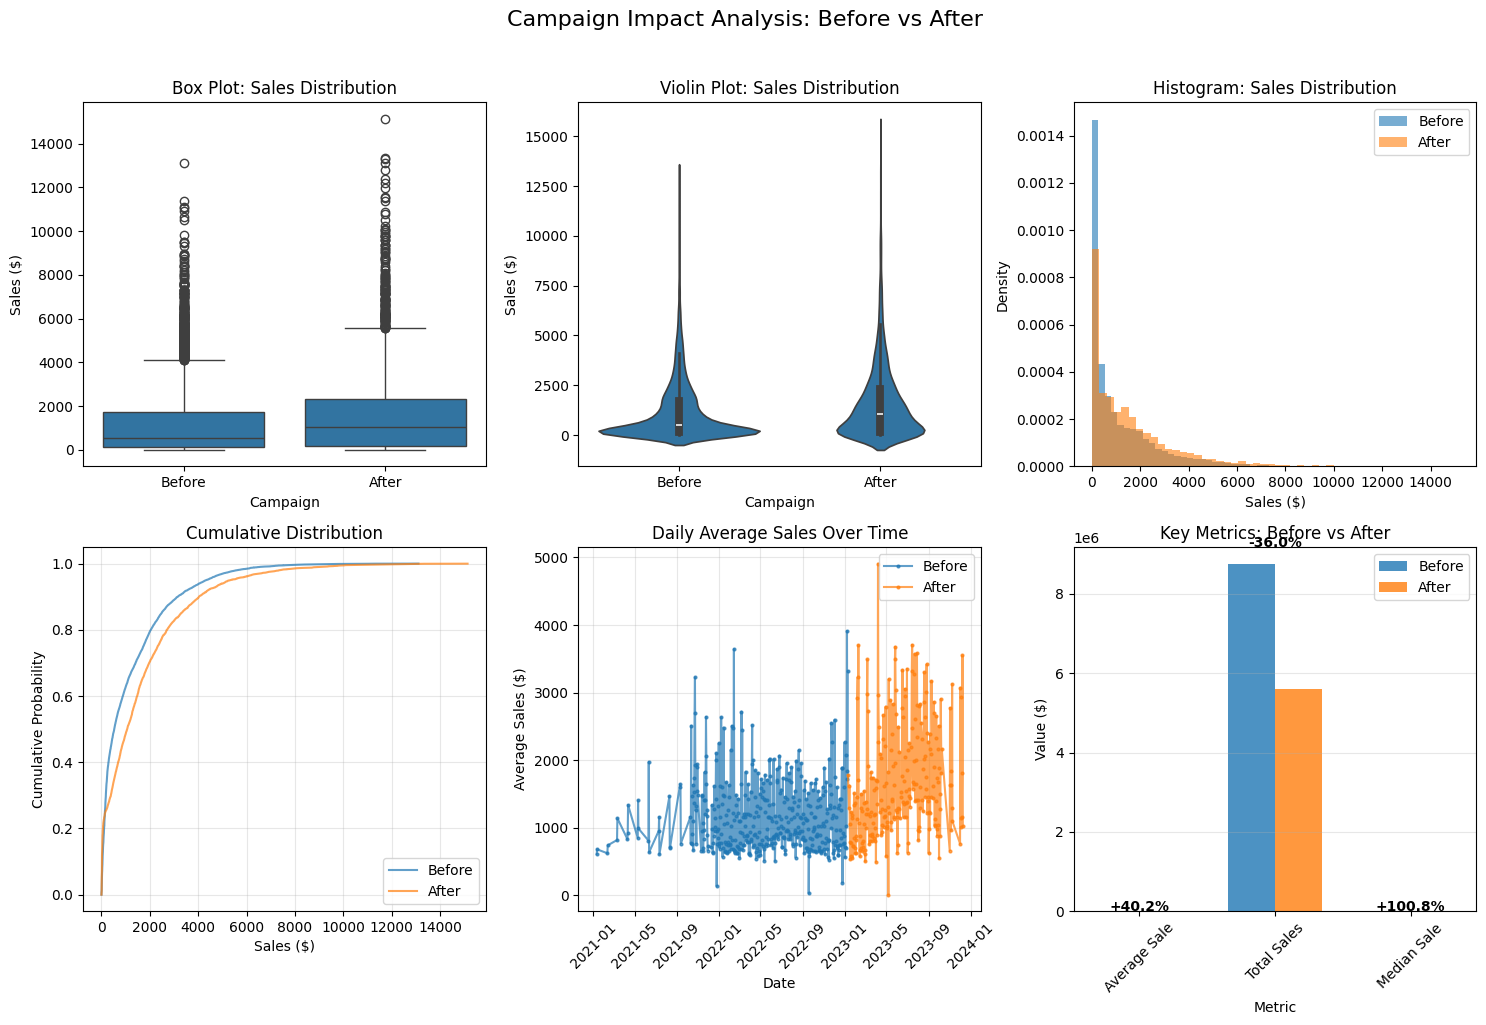


🔬 STATISTICAL SIGNIFICANCE TESTS:
T-test (Welch's): t = 12.707, p = 0.000000
  SIGNIFICANT (p < 0.05)
Mann-Whitney U test: U = 14544299, p = 0.000000
  SIGNIFICANT (p < 0.05)
Effect size (Cohen's d): 0.287
  Interpretation: Small effect

📏 95% CONFIDENCE INTERVALS:
Before: $1163.47 ($1129.75 - $1197.18)
After:  $1631.13 ($1567.33 - $1694.92)

🏆 TOP 5 BRANDS PERFORMANCE BY CAMPAIGN:
Producto 9:
  Before: $3396.29
  After:  $5284.71
  Change: +55.6%
------------------------------
Producto 6:
  Before: $3587.77
  After:  $3346.40
  Change: -6.7%
------------------------------
Producto 5:
  Before: $3262.19
  After:  $2618.36
  Change: -19.7%
------------------------------
Producto 14:
  Before: $2465.39
  After:  $2022.59
  Change: -18.0%
------------------------------
Producto 7:
  Before: $1273.41
  After:  $3042.67
  Change: +138.9%
------------------------------

🎯 CAMPAIGN IMPACT SUMMARY
✅ RESULT: Campaign appears SUCCESSFUL
   Sales increased by 40.2% on average
   This difference 

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

print("=" * 60)
print("CAMPAIGN IMPACT ANALYSIS: BEFORE vs AFTER")
print("=" * 60)

# BASIC COMPARISON STATISTICS
print("\nSALES COMPARISON BY CAMPAIGN PERIOD:")
campaign_stats = df.groupby('Campaign')['sales'].agg([
    'count', 'sum', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print(campaign_stats)

# Calculate percentage change
before_mean = campaign_stats.loc['Before', 'mean']
after_mean = campaign_stats.loc['After', 'mean']
pct_change = ((after_mean - before_mean) / before_mean) * 100

print(f"\nAVERAGE SALES CHANGE: {pct_change:.1f}%")
print(f"   Before: ${before_mean:.2f}")
print(f"   After:  ${after_mean:.2f}")

# VISUALIZATION: BEFORE VS AFTER DISTRIBUTION
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Campaign Impact Analysis: Before vs After', fontsize=16, y=1.02)

# Boxplot
sns.boxplot(data=df, x='Campaign', y='sales', ax=axes[0, 0])
axes[0, 0].set_title('Box Plot: Sales Distribution')
axes[0, 0].set_ylabel('Sales ($)')

# Violin plot
sns.violinplot(data=df, x='Campaign', y='sales', ax=axes[0, 1])
axes[0, 1].set_title('Violin Plot: Sales Distribution')
axes[0, 1].set_ylabel('Sales ($)')

# Histogram overlay
for campaign in ['Before', 'After']:
    campaign_data = df[df['Campaign'] == campaign]['sales']
    axes[0, 2].hist(campaign_data, bins=50, alpha=0.6, label=campaign, density=True)
axes[0, 2].set_title('Histogram: Sales Distribution')
axes[0, 2].set_xlabel('Sales ($)')
axes[0, 2].set_ylabel('Density')
axes[0, 2].legend()

# Cumulative distribution
for campaign in ['Before', 'After']:
    campaign_data = df[df['Campaign'] == campaign]['sales'].sort_values()
    y = np.arange(len(campaign_data)) / len(campaign_data)
    axes[1, 0].plot(campaign_data, y, label=campaign, alpha=0.7)
axes[1, 0].set_title('Cumulative Distribution')
axes[1, 0].set_xlabel('Sales ($)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series (if date is available)
if 'date' in df.columns:
    # Aggregate by date and campaign
    daily_sales = df.groupby(['date', 'Campaign'])['sales'].mean().reset_index()
    
    # Sort by date
    daily_sales = daily_sales.sort_values('date')
    
    # Plot
    for campaign in ['Before', 'After']:
        campaign_data = daily_sales[daily_sales['Campaign'] == campaign]
        axes[1, 1].plot(campaign_data['date'], campaign_data['sales'], 
                       marker='o', markersize=2, label=campaign, alpha=0.7)
    axes[1, 1].set_title('Daily Average Sales Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Average Sales ($)')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

# Percentage change bar chart
categories = ['Average Sale', 'Total Sales', 'Median Sale']
before_values = [
    campaign_stats.loc['Before', 'mean'],
    campaign_stats.loc['Before', 'sum'],
    campaign_stats.loc['Before', 'median']
]
after_values = [
    campaign_stats.loc['After', 'mean'],
    campaign_stats.loc['After', 'sum'],
    campaign_stats.loc['After', 'median']
]
pct_changes = [((a-b)/b)*100 for a, b in zip(after_values, before_values)]

x = np.arange(len(categories))
width = 0.35
axes[1, 2].bar(x - width/2, before_values, width, label='Before', alpha=0.8)
axes[1, 2].bar(x + width/2, after_values, width, label='After', alpha=0.8)

# Add percentage change labels
for i, pct in enumerate(pct_changes):
    axes[1, 2].text(i, max(before_values[i], after_values[i]) * 1.05, 
                   f'{pct:+.1f}%', ha='center', fontweight='bold')

axes[1, 2].set_title('Key Metrics: Before vs After')
axes[1, 2].set_xlabel('Metric')
axes[1, 2].set_ylabel('Value ($)')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(categories, rotation=45)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 3. STATISTICAL TESTS
print("\n🔬 STATISTICAL SIGNIFICANCE TESTS:")

# Separate data
before_sales = df[df['Campaign'] == 'Before']['sales']
after_sales = df[df['Campaign'] == 'After']['sales']

# T-test (parametric)
t_stat, p_value_t = ttest_ind(after_sales, before_sales, equal_var=False)
print(f"T-test (Welch's): t = {t_stat:.3f}, p = {p_value_t:.6f}")
print(f"  {'SIGNIFICANT' if p_value_t < 0.05 else 'NOT SIGNIFICANT'} (p < 0.05)")

# Mann-Whitney U test (non-parametric)
u_stat, p_value_u = mannwhitneyu(after_sales, before_sales, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.0f}, p = {p_value_u:.6f}")
print(f"  {'SIGNIFICANT' if p_value_u < 0.05 else 'NOT SIGNIFICANT'} (p < 0.05)")

# Effect size (Cohen's d)
from scipy.stats import norm
n1, n2 = len(before_sales), len(after_sales)
sd_pooled = np.sqrt(((n1-1)*before_sales.std()**2 + (n2-1)*after_sales.std()**2) / (n1+n2-2))
cohens_d = (after_mean - before_mean) / sd_pooled
print(f"Effect size (Cohen's d): {cohens_d:.3f}")
print(f"  Interpretation: {'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'} effect")

# 4. CONFIDENCE INTERVALS
from scipy.stats import sem, t

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

before_mean, before_ci_low, before_ci_high = confidence_interval(before_sales)
after_mean, after_ci_low, after_ci_high = confidence_interval(after_sales)

print("\n📏 95% CONFIDENCE INTERVALS:")
print(f"Before: ${before_mean:.2f} (${before_ci_low:.2f} - ${before_ci_high:.2f})")
print(f"After:  ${after_mean:.2f} (${after_ci_low:.2f} - ${after_ci_high:.2f})")

# 5. TOP BRANDS PERFORMANCE BY CAMPAIGN
print("\n🏆 TOP 5 BRANDS PERFORMANCE BY CAMPAIGN:")

# Top 5 brands by total sales overall
top_5_brands = df.groupby('brand')['sales'].sum().nlargest(5).index

for brand in top_5_brands:
    brand_data = df[df['brand'] == brand]
    brand_before = brand_data[brand_data['Campaign'] == 'Before']['sales'].mean()
    brand_after = brand_data[brand_data['Campaign'] == 'After']['sales'].mean()
    brand_change = ((brand_after - brand_before) / brand_before * 100) if brand_before > 0 else np.nan
    
    if not np.isnan(brand_change):
        print(f"{brand}:")
        print(f"  Before: ${brand_before:.2f}")
        print(f"  After:  ${brand_after:.2f}")
        print(f"  Change: {brand_change:+.1f}%")
        print("-" * 30)

# 6. SUMMARY RECOMMENDATION
print("\n" + "=" * 60)
print("CAMPAIGN IMPACT SUMMARY")
print("=" * 60)

if p_value_t < 0.05:
    if after_mean > before_mean:
        print("✅ RESULT: Campaign appears SUCCESSFUL")
        print(f"   Sales increased by {pct_change:.1f}% on average")
        print(f"   This difference is statistically significant (p = {p_value_t:.4f})")
    else:
        print("❌ RESULT: Campaign appears UNSUCCESSFUL")
        print(f"   Sales decreased by {abs(pct_change):.1f}% on average")
        print(f"   This difference is statistically significant (p = {p_value_t:.4f})")
else:
    print("⚠️  RESULT: No statistically significant impact detected")
    print(f"   Sales changed by {pct_change:.1f}% on average")
    print(f"   But this difference is not statistically significant (p = {p_value_t:.4f})")

print("\n RECOMMENDATIONS:")
if pct_change > 10 and p_value_t < 0.05:
    print("   • Campaign was highly successful - consider scaling similar initiatives")
elif pct_change > 0 and p_value_t < 0.05:
    print("   • Campaign had positive impact - refine and repeat")
elif pct_change < 0 and p_value_t < 0.05:
    print("   • Campaign had negative impact - analyze what went wrong")
else:
    print("   • Campaign impact inconclusive - gather more data or test different approaches")

print("=" * 60)

# Hipotesis

===HYPOTHESIS TESTING FOR CAMPAIGN IMPACT===
Processing sales...
Skipping date: Not a numerical column

Campaign Impact Analysis Results:

Variable  Before_Mean  After_Mean  Percent_Change  Point_Biserial_Correlation  Cohen_d T_Test_P_Value  Significant_T_Test
   sales      1163.47     1631.13            40.2                       0.132    0.287        0.0000*                True

📊 SUMMARY:
  • 1 out of 1 variables show statistically significant differences (T-test, p < 0.05)
  • 1 out of 1 variables show statistically significant differences (Mann-Whitney, p < 0.05)

🏆 TOP 3 VARIABLES MOST AFFECTED BY CAMPAIGN:
  sales: increased by 40.2% (Cohen's d = 0.287)

📈 VISUALIZING SIGNIFICANT RESULTS:


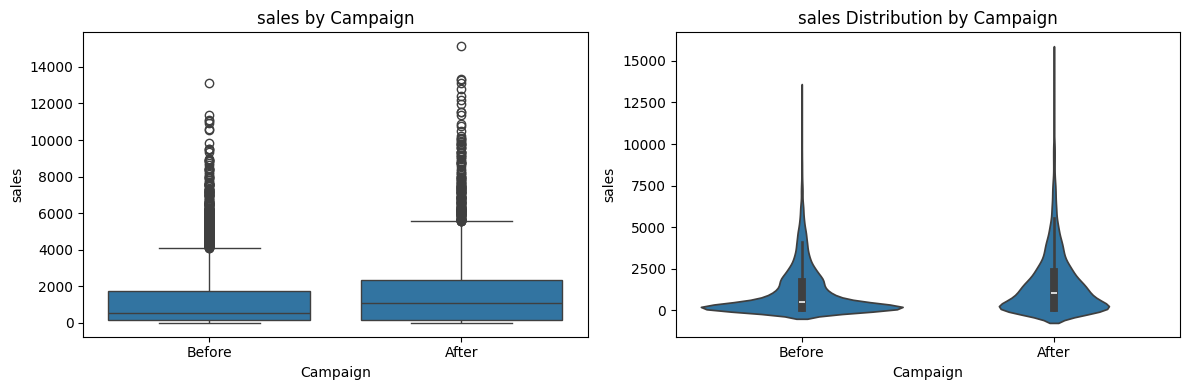

In [104]:
print("===HYPOTHESIS TESTING FOR CAMPAIGN IMPACT===")

test_results = []

for col in Num_cols:
    # Skip if it's not a numerical column
    if col == 'Campaign' or not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Skipping {col}: Not a numerical column")
        continue
    
    print(f"Processing {col}...")
    
    # Separate data by Campaign
    before_data = df[df['Campaign'] == 'Before'][col].dropna()
    after_data = df[df['Campaign'] == 'After'][col].dropna()
    
    if len(before_data) >= 10 and len(after_data) >= 10:
        # Calculate basic statistics
        before_mean = before_data.mean()
        after_mean = after_data.mean()
        mean_diff = after_mean - before_mean
        
        # Handle percentage change carefully
        try:
            pct_change = (mean_diff / abs(before_mean)) * 100 if before_mean != 0 else np.nan
        except (TypeError, ZeroDivisionError):
            pct_change = np.nan
        
        # 1. T-test for significant difference in means
        from scipy.stats import ttest_ind
        t_stat, p_val_ttest = ttest_ind(after_data, before_data, equal_var=False)
        
        # 2. Mann-Whitney U test (non-parametric)
        from scipy.stats import mannwhitneyu
        u_stat, p_val_mw = mannwhitneyu(after_data, before_data, alternative='two-sided')
        
        # 3. Cohen's d effect size
        n1, n2 = len(before_data), len(after_data)
        if n1 > 1 and n2 > 1:  # Need at least 2 samples for variance
            var1 = before_data.var()
            var2 = after_data.var()
            sd_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
            cohens_d = mean_diff / sd_pooled if sd_pooled != 0 else np.nan
        else:
            cohens_d = np.nan
        
        # 4. Point-biserial correlation
        try:
            combined_data = df[[col, 'Campaign']].dropna()
            combined_data['Campaign_numeric'] = combined_data['Campaign'].map({'Before': 0, 'After': 1})
            from scipy.stats import pointbiserialr
            pb_corr, pb_pval = pointbiserialr(combined_data[col], combined_data['Campaign_numeric'])
        except:
            pb_corr, pb_pval = np.nan, np.nan
        
        test_results.append({
            'Variable': col,
            'Before_Mean': before_mean,
            'After_Mean': after_mean,
            'Mean_Difference': mean_diff,
            'Percent_Change': pct_change,
            'T_Test_P_Value': p_val_ttest,
            'Mann_Whitney_P_Value': p_val_mw,
            'Point_Biserial_Correlation': pb_corr,
            'Cohen_d': cohens_d,
            'Significant_T_Test': p_val_ttest < 0.05,
            'Significant_MW': p_val_mw < 0.05
        })
    else:
        print(f"Skipping {col}: Not enough data (Before: {len(before_data)}, After: {len(after_data)})")

if test_results:
    results_df = pd.DataFrame(test_results)
    
    # Sort by absolute effect size (Cohen's d)
    results_df['Abs_Effect_Size'] = results_df['Cohen_d'].abs()
    results_df = results_df.sort_values('Abs_Effect_Size', ascending=False)
    
    print(f"\nCampaign Impact Analysis Results:\n")
    
    # Format for better display
    display_cols = ['Variable', 'Before_Mean', 'After_Mean', 'Percent_Change', 
                    'Point_Biserial_Correlation', 'Cohen_d', 'T_Test_P_Value', 'Significant_T_Test']
    
    display_df = results_df[display_cols].round({
        'Before_Mean': 2,
        'After_Mean': 2,
        'Percent_Change': 1,
        'Point_Biserial_Correlation': 3,
        'Cohen_d': 3,
        'T_Test_P_Value': 4
    })
    
    # Add symbols for significance
    def add_sig_symbol(p_val, sig):
        if sig:
            return f"{p_val:.4f}*"
        return f"{p_val:.4f}"
    
    display_df['T_Test_P_Value'] = [add_sig_symbol(p, s) for p, s in 
                                     zip(results_df['T_Test_P_Value'], results_df['Significant_T_Test'])]
    
    print(display_df.to_string(index=False))
    
    # Summary statistics
    n_significant_ttest = results_df['Significant_T_Test'].sum()
    n_significant_mw = results_df['Significant_MW'].sum()
    
    print(f"\n📊 SUMMARY:")
    print(f"  • {n_significant_ttest} out of {len(results_df)} variables show statistically significant differences (T-test, p < 0.05)")
    print(f"  • {n_significant_mw} out of {len(results_df)} variables show statistically significant differences (Mann-Whitney, p < 0.05)")
    
    # Top 3 most affected variables
    print(f"\n🏆 TOP 3 VARIABLES MOST AFFECTED BY CAMPAIGN:")
    top_3 = results_df.head(3)
    for i, row in top_3.iterrows():
        if pd.notna(row['Percent_Change']):
            direction = "increased" if row['Percent_Change'] > 0 else "decreased"
            print(f"  {row['Variable']}: {direction} by {abs(row['Percent_Change']):.1f}% (Cohen's d = {row['Cohen_d']:.3f})")
        else:
            print(f"  {row['Variable']}: Cohen's d = {row['Cohen_d']:.3f} (percentage change not applicable)")
    
    # Visualization of significant results
    print(f"\n📈 VISUALIZING SIGNIFICANT RESULTS:")
    
    significant_vars = results_df[results_df['Significant_T_Test']]['Variable'].tolist()
    
    if significant_vars:
        fig, axes = plt.subplots(len(significant_vars), 2, figsize=(12, 4*len(significant_vars)))
        if len(significant_vars) == 1:
            axes = axes.reshape(1, -1)
        
        for idx, var in enumerate(significant_vars):
            # Boxplot
            sns.boxplot(data=df, x='Campaign', y=var, ax=axes[idx, 0])
            axes[idx, 0].set_title(f'{var} by Campaign')
            axes[idx, 0].set_ylabel(var)
            
            # Violin plot
            sns.violinplot(data=df, x='Campaign', y=var, ax=axes[idx, 1])
            axes[idx, 1].set_title(f'{var} Distribution by Campaign')
            axes[idx, 1].set_ylabel(var)
        
        plt.tight_layout()
        plt.show()
    else:
        print("  No statistically significant results to visualize")
    
else:
    print("No hypothesis tests could be performed")